# Chapter 5 - Resampling Methods

In [1]:
import io
import requests
import warnings
warnings.filterwarnings('ignore')

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model as skl_lm
from sklearn.datasets import load_iris
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, LeaveOneOut, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.utils import resample
%matplotlib inline

BASE_DIR = 'https://gitlab.com/machine-learning-course1/ml-practice-lg-2024-spring/-/raw/master/Notebooks'

## 1. Cross Validation

### 1.1. Load dataset

Dataset available on http://www-bcf.usc.edu/~gareth/ISL/data.html

In [2]:
df = pd.read_csv(f'{BASE_DIR}/Data/Auto.csv', na_values='?').dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 0 to 396
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   year          392 non-null    int64  
 7   origin        392 non-null    int64  
 8   name          392 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 30.6+ KB


### 1.2. Validation Set Approach (Figure 5.2)
We will use polynomial feature generation in scikit-learn<BR>
http://scikit-learn.org/dev/modules/preprocessing.html#generating-polynomial-features

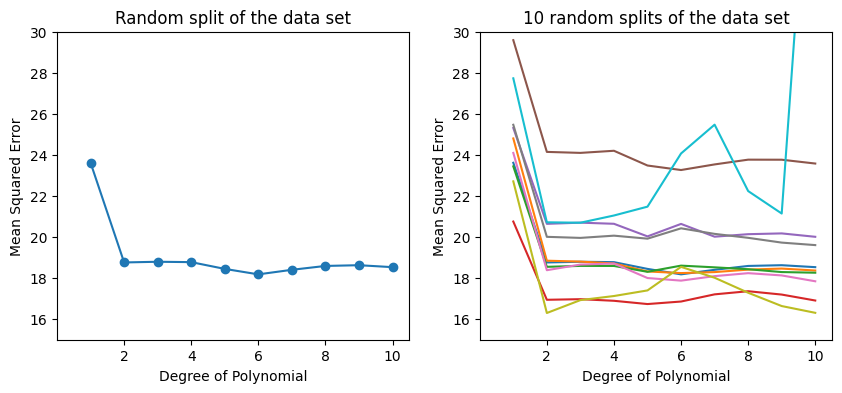

In [3]:
test_size = 0.5
degrees = range(1, 11)
MSEs = np.zeros((10, 10))

# Generate 10 random splits of the dataset (10개 polynomial degree * 10 random splits = 100 iterations)
for degree in degrees:
    for random_state in range(10):
        poly = PolynomialFeatures(degree)
        X = poly.fit_transform(df.horsepower.values.reshape(-1,1))
        y = df.mpg.ravel()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

        regr = skl_lm.LinearRegression()
        regr.fit(X_train, y_train)
        y_pred = regr.predict(X_test)
        MSEs[degree-1,random_state]= mean_squared_error(y_test, y_pred)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

# Left plot (first split)
ax1.plot(degrees, MSEs[:, 0], '-o')
ax1.set_title('Random split of the data set')

# Right plot (all splits)
ax2.plot(degrees, MSEs)
ax2.set_title('10 random splits of the data set')

for ax in fig.axes:
    ax.set_ylabel('Mean Squared Error')
    ax.set_ylim(15, 30)
    ax.set_xlabel('Degree of Polynomial')
    ax.set_xlim(0, 10.5)
    ax.set_xticks(range(2, 11, 2));

### 1.3. Compare LOOCV, 10-fold, 5-fold cross validation (Figure 5.4)

In [4]:
degrees = range(1,11)

In [5]:
# LeaveOneOut Cross Validation
regr = skl_lm.LinearRegression()
loo = LeaveOneOut()

score_raw_loo = np.zeros([10, df.shape[0]])
score_mean_loo = []

for degree in degrees:
    poly = PolynomialFeatures(degree)
    X = poly.fit_transform(df.horsepower.values.reshape(-1,1))
    y = df.mpg.ravel()
    
    scores = cross_val_score(regr, X, y, cv=loo, scoring='neg_mean_squared_error')
    
    score_raw_loo[degree-1,:] = scores
    score_mean_loo.append(np.mean(scores))

In [6]:
# 10-fold Cross Validation
folds = 10

kf_10 = KFold(n_splits=folds)

score_raw_10fold = np.zeros([10, folds])
score_mean_10fold = []

for degree in degrees:
    poly = PolynomialFeatures(degree)
    X = poly.fit_transform(df.horsepower.values.reshape(-1,1))
    y = df.mpg.ravel()
    
    scores = cross_val_score(regr, X, y, cv=kf_10, scoring='neg_mean_squared_error')
    
    score_raw_10fold[degree-1,:] = scores
    score_mean_10fold.append(np.mean(scores))

In [7]:
# 5-fold Cross Validation
folds = 5

score_raw_5fold = np.zeros([10, folds])
score_mean_5fold = []

for degree in degrees:
    poly = PolynomialFeatures(degree)
    X = poly.fit_transform(df.horsepower.values.reshape(-1,1))
    y = df.mpg.ravel()
    
    scores = cross_val_score(regr, X, y, cv=folds, scoring='neg_mean_squared_error')
    
    score_raw_5fold[degree-1,:] = scores
    score_mean_5fold.append(np.mean(scores))

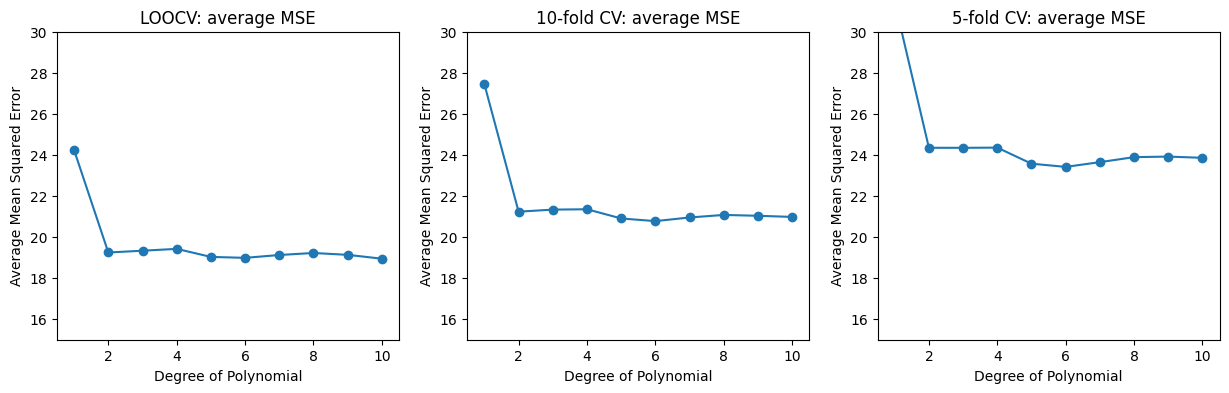

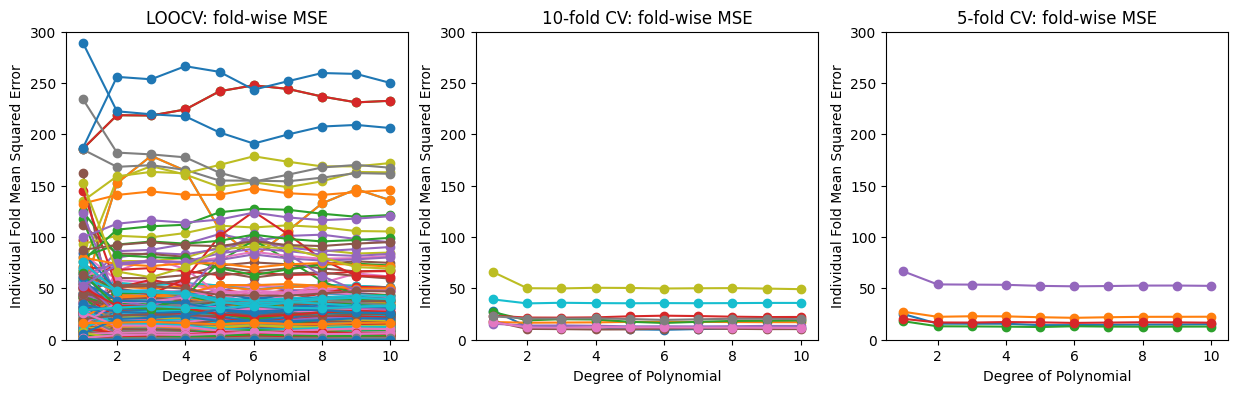

In [8]:
## Upper plot
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))

# Left plot
ax1.set_title('LOOCV: average MSE')
ax1.plot(degrees, np.array(score_mean_loo)*-1, '-o')

# Middle plot
ax2.set_title('10-fold CV: average MSE')
ax2.plot(degrees, np.array(score_mean_10fold)*-1,'-o')

# Right plot
ax3.set_title('5-fold CV: average MSE')
ax3.plot(degrees, np.array(score_mean_5fold)*-1,'-o')

for ax in fig.axes:
    ax.set_ylabel('Average Mean Squared Error')
    ax.set_ylim(15, 30)
    ax.set_xlabel('Degree of Polynomial')
    ax.set_xlim(0.5, 10.5)
    ax.set_xticks(range(2, 11, 2));
plt.show()
    

## Lower plot
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))

# Left plot
for i in range(df.shape[0]):
    ax1.set_title('LOOCV: fold-wise MSE')
    ax1.plot(degrees, score_raw_loo[:,i]*-1,'-o')

# Middle plot
for i in range(10):
    ax2.set_title('10-fold CV: fold-wise MSE')
    ax2.plot(degrees, score_raw_10fold[:,i]*-1,'-o')

# Right plot
for i in range(5):
    ax3.set_title('5-fold CV: fold-wise MSE')
    ax3.plot(degrees, score_raw_5fold[:,i]*-1,'-o')

for ax in fig.axes:
    ax.set_ylabel('Individual Fold Mean Squared Error')
    ax.set_ylim(0, 300)
    ax.set_xlabel('Degree of Polynomial')
    ax.set_xlim(0.5, 10.5)
    ax.set_xticks(range(2, 11, 2));
plt.show()

## 1.4. Exercise

This time, we will repeat the above process using the (weight, mpg) as the dataset.

1. Load f'{BASE_DIR}/Data/Auto.csv', and plot the scatter plot of the ('weight', 'mpg') from the loaded dataset.
2. Compare LOOCV, 10-fold, 5-fold cross validation by plotting the average MSE and the fold-wise MSE. 

In [ ]:
# Load f'{BASE_DIR}/Data/Auto.csv'



# Plot the scatter plot of the ('weight', 'mpg') from the loaded dataset.







In [ ]:
# Compare LOOCV, 10-fold, 5-fold cross validation by plotting the average MSE and the fold-wise MSE



































## 2. Bootstrap
### 2.1. Simulate 4 different datasets and estimate  $\alpha$

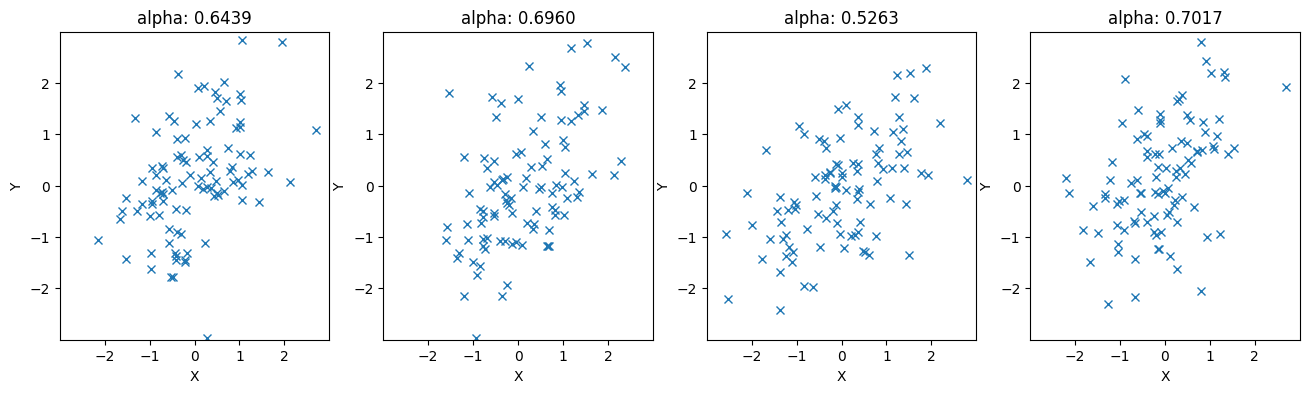

In [11]:
mean = [0, 0]
cov = [[1,   0.5],
       [0.5, 1.25]]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16,4))
n_samples = 100

def calc_alpha(x, y):
    '''
    Lecture5-2 Cross Validation, slide 36/66
    '''
    var_x = np.var(x)
    var_y = np.var(y)
    cov_xy = np.cov(x,y)[0,1]
    a_hat = (var_y - cov_xy)/(var_x + var_y - 2*cov_xy)
    return a_hat

# 1st plot
x, y = np.random.multivariate_normal(mean, cov, n_samples).T
title = 'alpha: {:.4f}'.format(calc_alpha(x, y))
ax1.set_title(title)
ax1.plot(x, y, 'x')

# 2nd plot
x, y = np.random.multivariate_normal(mean, cov, n_samples).T
title = 'alpha: {:.4f}'.format(calc_alpha(x, y))
ax2.set_title(title)
ax2.plot(x, y, 'x')

# 3rd plot
x, y = np.random.multivariate_normal(mean, cov, n_samples).T
title = 'alpha: {:.4f}'.format(calc_alpha(x, y))
ax3.set_title(title)
ax3.plot(x, y, 'x')

# 4th plot
x, y = np.random.multivariate_normal(mean, cov, n_samples).T
title = 'alpha: {:.4f}'.format(calc_alpha(x, y))
ax4.set_title(title)
ax4.plot(x, y, 'x')

for ax in fig.axes:
    ax.set_ylabel('Y')
    ax.set_ylim(-3, 3)
    ax.set_xlabel('X')
    ax.set_xlim(-3, 3)
    ax.set_xticks(range(-2, 3, 1));
    ax.set_yticks(range(-2, 3, 1));

### 2.2. Repeat the above process 1000 time and plot histograms of $\alpha$

Estimated alpha from 1000 simulated datasets: 0.5999 +- 0.0814


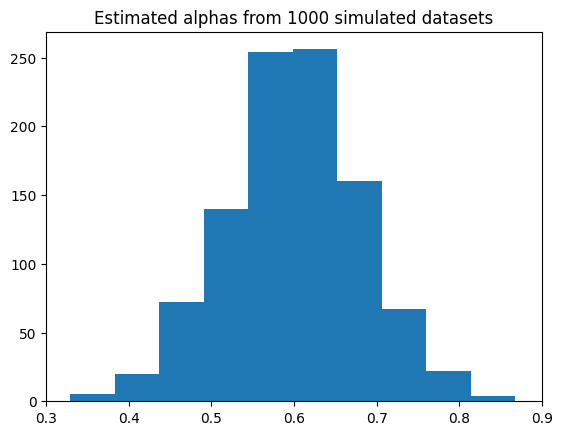

In [12]:
a_hat_list = []
for i in range(1000):
    x, y = np.random.multivariate_normal(mean, cov, n_samples).T
    a_hat_list.append(calc_alpha(x, y))

print('Estimated alpha from 1000 simulated datasets: {:.4f} +- {:.4f}'.format(np.mean(a_hat_list), np.std(a_hat_list)))

plt.figure()
plt.title('Estimated alphas from 1000 simulated datasets')
plt.hist(a_hat_list)
plt.xlim(0.3, 0.9)
plt.show()

### 2.3. Generate 1000 bootstrap datasets and estimate $\alpha$

To create bootstrap datasets, we can use sklearn.utils.resample() function
e.g., x_hat, y_hat = resample(x, y, n_samples=n_samples)

Estimated alpha from 1000 bootstrap datasets from a single simulation dataset: 0.6283 +- 0.0843


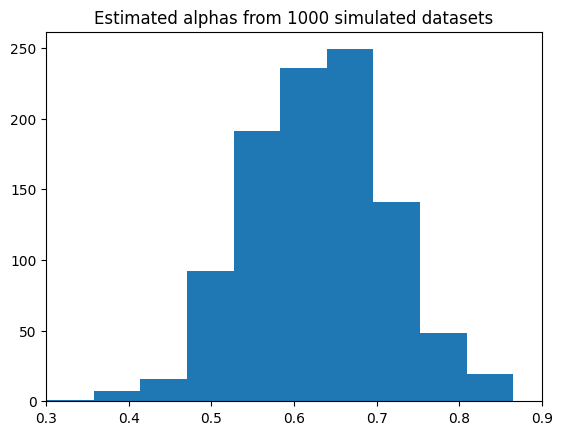

In [13]:
# sample one (x,y) dataset
x, y = np.random.multivariate_normal(mean, cov, n_samples).T

# generate 1000 bootstrap samples, estimate alpha, and save
a_hat_list = []
for i in range(1000):
    x_hat, y_hat = resample(x, y, n_samples=n_samples)
    a_hat_list.append(calc_alpha(x_hat, y_hat))

print('Estimated alpha from 1000 bootstrap datasets from a single simulation dataset: {:.4f} +- {:.4f}'.format(np.mean(a_hat_list), np.std(a_hat_list)))

# plot the histrogram of the estimated alphas
plt.figure()
plt.title('Estimated alphas from 1000 simulated datasets')
plt.hist(a_hat_list)
plt.xlim(0.3, 0.9)
plt.show()

## 3. Automation

### 3.1. Pipeline

In [14]:
standard_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=2)),
], memory='.', verbose=True)

In [15]:
standard_knn.get_params()

{'memory': '.',
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=2))],
 'verbose': True,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=2),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 2,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [16]:
standard_knn.set_params(knn__n_neighbors=1)
standard_knn.get_params()

{'memory': '.',
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=1))],
 'verbose': True,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=1),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 1,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [17]:
iris = load_iris()

X = iris.data
y = iris.target
target_names = iris.target_names

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((120, 4), (30, 4), (120,), (30,))

In [18]:
standard_knn.fit(X_train, y_train)

[Pipeline] ............... (step 2 of 2) Processing knn, total=   0.0s


Pipeline(memory='.',
         steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=1))],
         verbose=True)

In [19]:
y_pred = standard_knn.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.91      1.00      0.95        10
   virginica       1.00      0.90      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



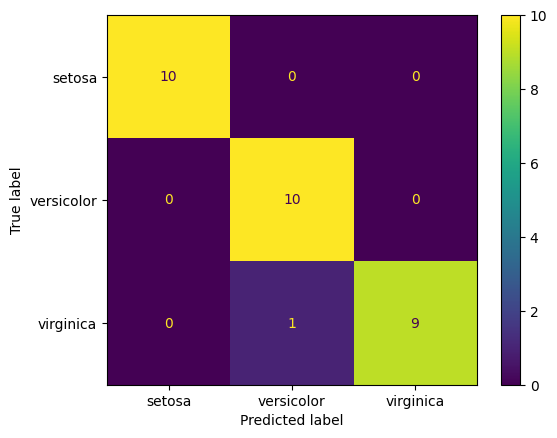

In [20]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=target_names)
disp.plot()

[Pipeline] ............... (step 2 of 2) Processing knn, total=   0.0s
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00        10
   virginica       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



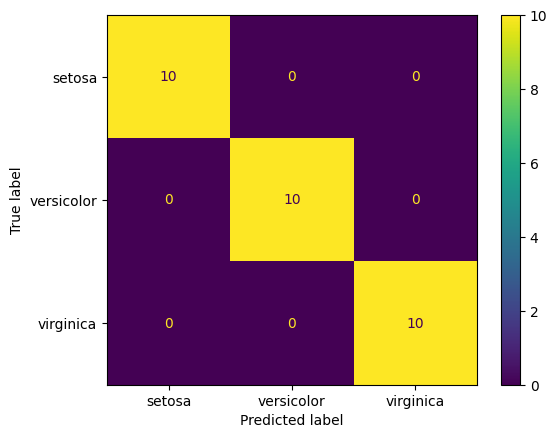

In [21]:
standard_knn.set_params(knn__n_neighbors=15)
standard_knn.fit(X_train, y_train)
y_pred = standard_knn.predict(X_test)

print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=target_names)
disp.plot()

### 3.2. Grid Search

In [22]:
standard_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=2)),
], memory='.')

# Set the parameters by cross-validation
tuned_parameters = [
    {
        'scaler__with_mean': [True],
        'knn__n_neighbors': [1, 2, 3, 4, 5],
    },
    {
        'scaler__with_mean': [False],
        'knn__n_neighbors': [15, 30],
    }
]

scores = ['precision_macro', 'recall_macro']

for score in scores:
    print('-'*50)
    print('# Tuning hyper-parameters for {}\n'.format(score))

    clf = GridSearchCV(
        standard_knn, tuned_parameters, scoring=score, cv=5, n_jobs=-1
    )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print()
    
    print("Grid scores on development set:")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print('{:.3f} (+/-{:.3f}) for {}'.format(mean, 2*std, params))
    print()
    
    print("Detailed classification report:")
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

--------------------------------------------------
# Tuning hyper-parameters for precision_macro

Best parameters set found on development set:
{'knn__n_neighbors': 4, 'scaler__with_mean': True}

Grid scores on development set:
0.939 (+/-0.042) for {'knn__n_neighbors': 1, 'scaler__with_mean': True}
0.934 (+/-0.062) for {'knn__n_neighbors': 2, 'scaler__with_mean': True}
0.938 (+/-0.065) for {'knn__n_neighbors': 3, 'scaler__with_mean': True}
0.951 (+/-0.029) for {'knn__n_neighbors': 4, 'scaler__with_mean': True}
0.948 (+/-0.039) for {'knn__n_neighbors': 5, 'scaler__with_mean': True}
0.942 (+/-0.037) for {'knn__n_neighbors': 15, 'scaler__with_mean': False}
0.899 (+/-0.085) for {'knn__n_neighbors': 30, 'scaler__with_mean': False}

Detailed classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.91      1.00      0.95        10
           2       1.00      0.90      0.95        10

    accuracy 

## 4. Application: Face Verification

Finally, we will go through how we can apply K-Fold cross validation on the task of face verification (i.e., determining whether a pair of faces belong to the same identity). 

### 4.1. Load Labeled Faces in the Wild (LFW) benchmark dataset [1]

[1] G. Huang et al., "Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments," Technical report 2007.

In [23]:
LFW = h5py.File(io.BytesIO(requests.get(f'{BASE_DIR}/Data/LFW.hdf5').content), "r+")
faces = LFW["imgs"]
labels = LFW["labels"]
labels = np.asarray(labels)

### 4.2. Dataset Exploration

Provided dataset contains 500 pairs of faces, each marked with a label indicating whether the two faces are the same person. Randomly pick an index, and see how the faces in the dataset looks like.

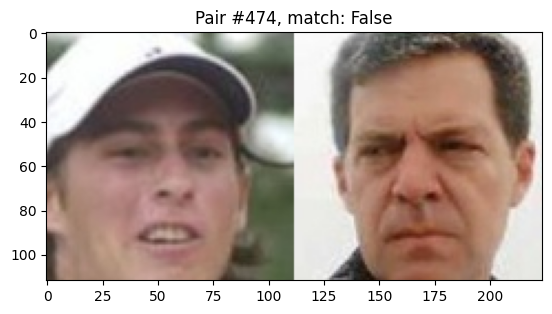

In [24]:
# select random index
idx = np.random.randint(labels.shape[0])
img1 = faces[2*idx]
img2 = faces[2*idx+1]
match = labels[idx]

# plot
plt.figure()
plt.imshow(np.concatenate([img1, img2], axis = 1))
title = "Pair #%d, match: %r"%(idx, match)
plt.title(title)
plt.show()

### 4.3. Load Face Features 

Load face features extracted by ArcFace [2] recognition network with ResNet50 backbone

[2] J. Deng et al., "ArcFace: Additive Angular Margin Loss for Deep Face Recognition," CVPR 2019.

In [25]:
embeddings = np.load(io.BytesIO(requests.get(f'{BASE_DIR}/Data/embeddings.npy').content))
print(embeddings.shape)

(1000, 512)


### 4.4. Calculate Feature Distances Between the Two Faces

Face verification works by extracting the feature vectors for a pair of input faces, normalizing them, and calculating the L2 distance, and comparing against a threshold.

Implement the calc_distance() function which calculates the L2 distance between the two feature vectors $x$ and $y$, i.e.,

calc_distance($x$, $y$) = $\sum_{i=1}^n (x_{i}/||x||-y_{i}/||y||)^2$,

where n is the length of the feature vector, and $||x||, ||y||$ is the L2 norm of $x$ and $y$ calculated by

$||x|| = (\sum_{i=1}^n x_{i}^2)^{1/2}.$

You can use np.linalg.norm() to calculate the norm of the feature vector

(500,)


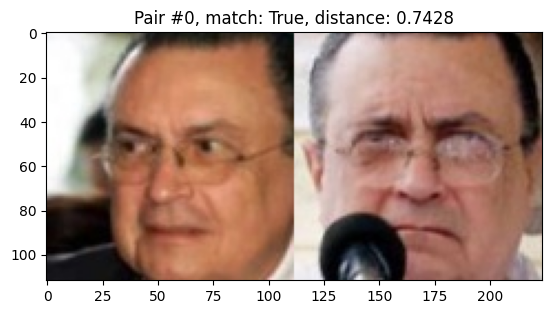

In [26]:
def calc_distance(feature1, feature2):
    # normalize feature 1 and feature 2
    feature1 /= np.linalg.norm(feature1)
    feature2 /= np.linalg.norm(feature2)
    
    # calculate the l2 distance
    distance = np.sum(np.square(feature1-feature2))

    return distance

embeddings1 = embeddings[0::2]
embeddings2 = embeddings[1::2]

# calculate distance
diff = np.subtract(embeddings1, embeddings2)
dist = np.sum(np.square(diff), 1)

print(dist.shape)

idx = 0
#idx = np.random.randint(labels.shape[0])
img1 = faces[2*idx]
img2 = faces[2*idx+1]
match = labels[idx]
distance = dist[idx]

# plot
plt.figure()
plt.imshow(np.concatenate([img1, img2], axis = 1))
title = "Pair #%d, match: %r, distance: %.4f"%(idx, match, distance) # should be 0.7428
plt.title(title)
plt.show()

### 4.5. Plot (Receiver Operating Characteristic) ROC curve

An ROC curve is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.

It is created by plotting the true positive rate ($TPR$) against the false positive rate ($FPR$) at various threshold settings. TPR and FPR are calculated as follows:

$ TPR = TP / (TP + FN), $

$ FPR = FP / (FP + TN) $

where $TP, TN, FP, FN$ are True Positive, True Negative, False Positive, and False Negative, respectively.

![Labels](https://gitlab.com/machine-learning-course1/ml-practice-lg-2024-spring/-/raw/main/Images/labels.png)

Finally, the accuracy is defined as follows,

$accuracy = (TP+TN)/(TP+TN+FP+FN).$

Try implement calculate_roc($threshold$, $dist$, $label$) function, which calculates the TPR, FPR, and accuracy for the list of feature distance values $dist$ and ground truth labels $label$ and a threshold $threshold$.

[]

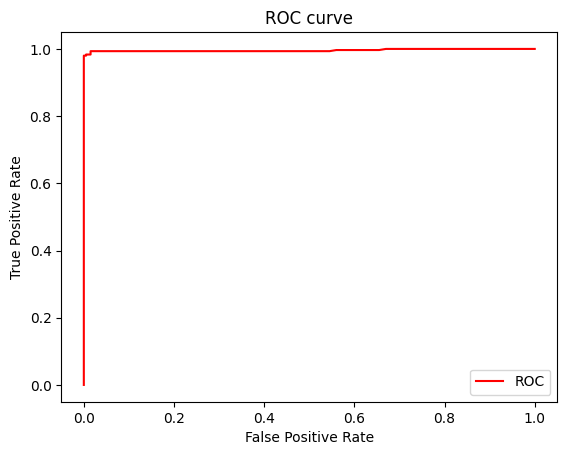

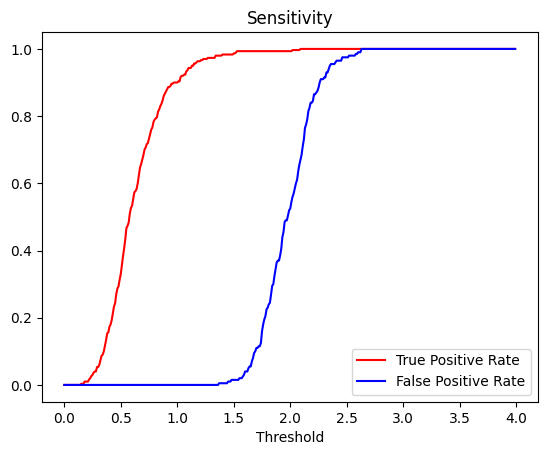

In [27]:
def calculate_roc(threshold, distances, labels):
    # threshold: a threshold value (float). If distance is below the threshold, we determine that the two faces are the same
    # distances: a list of distance values between pairs of two faces
    # labels: a list of labels (boolean) indicating the ground truth of whether the two faces match or not
    
    # predict the results based on the calculated distance and the given threshold
    predict = np.less(distances, threshold)
    
    # calculate TP/FP/TN/FN
    tp = np.sum(np.logical_and(predict, labels))
    fp = np.sum(np.logical_and(predict, np.logical_not(labels)))
    tn = np.sum(np.logical_and(np.logical_not(predict), np.logical_not(labels)))
    fn = np.sum(np.logical_and(np.logical_not(predict), labels))

    # calculate TPR, FPR and accuracy
    TPR = 0 if (tp + fn == 0) else float(tp) / float(tp + fn)
    FPR = 0 if (fp + tn == 0) else float(fp) / float(fp + tn)
    acc = float(tp + tn) / distances.size
    return TPR, FPR, acc

# for each threshold, calculate metrics necessary to draw the ROC curve
thresholds = np.arange(0, 4, 0.01)
TPR = np.zeros((len(thresholds)))
FPR = np.zeros((len(thresholds)))
for threshold_idx, threshold in enumerate(thresholds):
    TPR[threshold_idx], FPR[threshold_idx], _ = calculate_roc(threshold, dist, labels)
    
# plot ROC curve
fig = plt.figure()
plt.plot(FPR, TPR, color = 'r', label = 'ROC')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
_title = "ROC curve"
plt.title(_title)
plt.legend()
plt.plot()

# plot sensitivity curve
fig = plt.figure()
plt.plot(thresholds, TPR, color = 'r', label = 'True Positive Rate')
plt.plot(thresholds, FPR, color = 'b', label = 'False Positive Rate')
plt.xlabel("Threshold")
_title = "Sensitivity"
plt.title(_title)
plt.legend()
plt.plot()

### 4.6. Calculate accuracy

Finally, let's find the best distance threshold for the LFW dataset by performing a K-Fold cross validation.

In [28]:
folds = 10

n_pairs = min(len(labels), embeddings1.shape[0])
n_thresholds = len(thresholds)
k_fold = KFold(n_splits=folds, shuffle=True)

accuracy = np.zeros((folds))
indices = np.arange(n_pairs)

for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):
    # Find the best threshold for the fold
    acc_train = np.zeros((n_thresholds))
    for threshold_idx, threshold in enumerate(thresholds):
        _, _, acc_train[threshold_idx] = calculate_roc(threshold, dist[train_set], labels[train_set])
    best_threshold_index = np.argmax(acc_train)
    print('best threshold for fold %d: %.2f (test fold accuracy %.4f)' 
          %(fold_idx, thresholds[best_threshold_index], acc_train[best_threshold_index]))

    _, _, accuracy[fold_idx] = calculate_roc(thresholds[best_threshold_index], 
                                                  dist[test_set], labels[test_set])
print("Best threshold accuracy: %.2f"%thresholds[best_threshold_index])
acc, std = np.mean(accuracy), np.std(accuracy)
print('Fold accuracy: %.4f+-%.4f' % (acc, std))

best threshold for fold 0: 1.53 (test fold accuracy 0.9889)
best threshold for fold 1: 1.34 (test fold accuracy 0.9889)
best threshold for fold 2: 1.40 (test fold accuracy 0.9911)
best threshold for fold 3: 1.53 (test fold accuracy 0.9911)
best threshold for fold 4: 1.53 (test fold accuracy 0.9956)
best threshold for fold 5: 1.53 (test fold accuracy 0.9889)
best threshold for fold 6: 1.34 (test fold accuracy 0.9889)
best threshold for fold 7: 1.53 (test fold accuracy 0.9889)
best threshold for fold 8: 1.53 (test fold accuracy 0.9889)
best threshold for fold 9: 1.34 (test fold accuracy 0.9889)
Best threshold accuracy: 1.34
Fold accuracy: 0.9820+-0.0189
